<a href="https://colab.research.google.com/github/JacobTumak/SentimentAnalysisProject/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing**

In [5]:
from google.colab import output
from dataclasses import dataclass
from string import punctuation
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk import (sent_tokenize, word_tokenize)
nltk.download(['punkt', 'stopwords', 'wordnet'])
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
stop_words += ['br', "''", "``"] + list(punctuation)
from collections import Counter
from pprint import pprint
import glob
from itertools import islice
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
train_dir = f"/content/drive/MyDrive/Train/"
test_dir = f"/content/drive/MyDrive/Train/Test/"
POS=1;NEG=0

def fetch_text(directory, limit=100):
  POS = 1; NEG = 0
  num_pos = limit//2
  num_neg = limit - num_pos
  text = []
  num_files = 0
  while num_files<limit:
    for int_type in [POS, NEG]:
      if int_type == POS:
        n = num_pos; identifier = 'pos'
      else:
        n = num_neg; identifier = 'neg'
      file_paths = glob.glob(directory + identifier + "/*.txt")
      for file_path in islice(file_paths, n):
        with open(file_path, "r") as f:
          text_id = file_path[len(directory)+4:len(file_path)-4]
          text.append(TextFile(text_id, int_type, f.read()))
        num_files += 1
        output.clear()
        print(num_files)    
  return text

In [7]:
def re_init_TextFile(file_list):
  text = []
  for text_file in file_list:
    text.append(TextFile(text_file.name, text_file.identity, text_file.text))
  return text

# Classes

* Import text files into list
* remove stopwords and punctuation from each piece of text
* stem the remaining words with porter stemmer. Add to seperate lists to represent a review
* convert the list into a dict with format: 'word': word-frequency
* create a master list of all the words with the percent difference of sentiment:
  ```
{word: sum_freq_pos/len(pos_reviews)-sum_freq_neg/len(neg_reviews)}
```

Needed Functions:


* fetch text file
* remove stopwords and punct
* stem words
* count frequency
* create sentiment data set






The TextFile class stores data for each individual text file imported from my google drive. 

In [8]:
NEG = 0; POS = 1
class TextFile:  
  def __init__(self, file_name, identity, text):
    self.name = file_name
    self.text = text
    self.identity = identity
    self.word_freq = dict()
    self.predicted = float()
    self.correct = bool
    self.__get_freq()

  def __get_word_list__(self):
    word_list = word_tokenize(self.text)
    word_list = [ps.stem(lemmatizer.lemmatize(word)) for word in word_list]
    return word_list


  def __get_freq(self):
    for word in self.__get_word_list__():
      if word in self.word_freq:
        self.word_freq[word].distribution[self.identity] += 1
      else:
        self.word_freq[word] = Word([0,0],0)
        self.word_freq[word].distribution[self.identity] += 1

The "Word" class stores the statistics for each word collected in the textfiles. This class makes it simple to obtain statistics for a word in a clean and efficeint way.

In [9]:
@dataclass
class Word:
  distribution: list
  score: float

The SentimentModel class is used to store statistical word data and use it to make predictions for text that is passed to it. It also contains functions to test various methods of optimizing the data in the class instance

In [23]:
class SentimentModel:

  def __init__(self, train_files):
    self.word_data = dict()
    self.add_word_data(train_files)
    self.accuracy_dist = list()
    self.difference = float()
    self.overall = float()
    self.num_rated = list()
    

  def add_word_data(self, train_files):
    for train_file in train_files:
      for word in train_file.word_freq:
        if word not in self.word_data:
          self.word_data[word] = train_file.word_freq[word]
        else:
          self.word_data[word].distribution[train_file.identity] += train_file.word_freq[word].distribution[train_file.identity]
    self.__calc_weights()

  def __calc_weights(self):
    for word in self.word_data.copy():
      dist = self.word_data[word].distribution
      if sum(dist) > 10 or abs(np.diff(dist)) > 0.2:
        # self.word_data[word].score = (dist[POS]-dist[NEG])/sum(dist)
        self.word_data[word].score = np.sqrt(abs(dist[POS]^2 - dist[NEG]^2)) * [-1, 1][dist[NEG] < dist[POS]]
      else:
        self.word_data.pop(word)


  def get_rating(self, text_file, exclude=list(), return_result = True):
    rating = 0; num_rated = 0
    assigned_sent = text_file.identity
    for word in text_file.word_freq:
      if word in self.word_data and word not in exclude:

        word_quantity = text_file.word_freq[word].distribution[assigned_sent]
        rating += self.word_data[word].score * word_quantity
        num_rated += word_quantity
    text_file.predicted = rating/num_rated
    compare_result = text_file.predicted + text_file.identity
    text_file.correct = compare_result < 0 or compare_result > 1
    if return_result: return text_file.correct



  def get_accuracy(self, text_files, exclude=list()):
    self.num_rated = [0,0]; self.accuracy_dist = [0,0]

    for text_file in text_files:
      assigned_sent = text_file.identity # 0 if neg, 1 if pos
      self.accuracy_dist[assigned_sent] += self.get_rating(text_file, exclude=exclude)

      self.num_rated[assigned_sent] += [-1, 1][assigned_sent] # adds one to pos if pos, subtracts one from neg if neg

    self.accuracy_dist = np.divide(self.accuracy_dist, self.num_rated)
    self.overall = (self.accuracy_dist[POS]-self.accuracy_dist[NEG])/2
    self.difference = sum(self.accuracy_dist)

  
  def optimize_by_word(self, init_test_files, interval=3, max_intervals = 500):
    optimized_stopwords = []; words = []
    test_files = init_test_files.copy()
    # test_model = self
    iters = 0; improvement = 0
    base_rating = self.overall
    word_order = dict(sorted(self.word_data.items(), key=lambda x:sum(x[1].score), reverse=False))
    for word in word_order:
      if iters < max_intervals * interval:
        words.append(word)
        iters+=1
        if iters % interval == 0:
          self.get_accuracy(test_files, exclude=words+optimized_stopwords)
          if self.overall > improvement:
            print(f"Word: {words}")
            improvement = self.overall
            print(f"  {improvement}\n  {iters//interval}")
            optimized_stopwords.extend(words)
            print()
          words = []
    print(base_rating, self.overall)
    return optimized_stopwords


  def optimize_by_file(self, init_test_files):
    test_files = init_test_files.copy()
    # test_model = self
    removed = []; iters = 0
    base_rating = self.overall
    while iters < 100:
      iters += 1
      excluded = dict()
      improvement = self.overall
      m_neutral = self.most_incorrect_prediction(test_files)
      print(f"File: {m_neutral.predicted}")
      for word in m_neutral.word_freq:
        self.get_accuracy(test_files, exclude=[word])
        excluded[self.overall] = word
        max_impact = max(excluded)
        if max_impact > improvement:
          improvement = max_impact
          print(f"  {max_impact}")
          try: self.word_data.pop(excluded[max_impact])
          except: continue
      test_files.remove(m_neutral)
      print()
    return base_rating, self.overall

  def most_neutral_file(self, test_files): # PUT THIS IN TEXT FILE LIST CLASS INSTEAD
    predicted_keys = {test_file.predicted: test_file for test_file in test_files}
    return predicted_keys[min(predicted_keys, key=abs)]
  
  def most_incorrect_prediction(self, test_files):
    predicted_keys = {test_file.predicted: test_file for test_file in test_files if test_file.correct == False}
    return predicted_keys[max(predicted_keys, key=abs)]

In [ ]:
train_files = fetch_text(train_dir, limit=2000)

In [34]:
test_files = fetch_text(test_dir, limit=600)

600


In [35]:
test_model = SentimentModel(train_files)

In [70]:
def rate_my_text(text, model):
  trial_text = TextFile("trial_text", 0, text)
  model.get_rating(trial_text)
  print(f'''Your text is overall {["negative", "positive"][int(trial_text.predicted)>0]} with a score of {round(trial_text.predicted,2)}''')

text = "today joe and I went to talk to bob about his alcoholism. He's on a path to recovery now"
rate_my_text(text, test_model)

Your text is overall positive with a score of 9.75


In [62]:
test_model.get_accuracy(test_files)
test_model.accuracy_dist

array([-0.96,  0.98])

In [61]:
test_model.word_data

{'trawl': Word(distribution=[0, 1], score=1.0),
 'through': Word(distribution=[1456, 1058], score=-19.949937343260004),
 'the': Word(distribution=[91973, 97243], score=85.58037158133867),
 'sci': Word(distribution=[21, 8], score=-5.0),
 'fi': Word(distribution=[21, 22], score=2.6457513110645907),
 'weekli': Word(distribution=[7, 29], score=5.291502622129181),
 'section': Word(distribution=[70, 57], score=-11.0),
 'of': Word(distribution=[38850, 43239], score=127.35383779062177),
 'local': Word(distribution=[357, 239], score=-20.0),
 'video': Word(distribution=[448, 351], score=-15.0),
 'rental': Word(distribution=[98, 36], score=-11.045361017187261),
 'store': Word(distribution=[105, 99], score=-2.8284271247461903),
 'i': Word(distribution=[25389, 22456], score=-116.00431026474836),
 'wa': Word(distribution=[15624, 12809], score=-62.08864630510155),
 'lose': Word(distribution=[182, 204], score=11.224972160321824),
 'hope': Word(distribution=[693, 596], score=-15.132745950421556),
 'fin

In [ ]:
my_stopwords = test_model.optimize_by_word(test_files)

Word: ['the', ',', '.']
  0.7715000000000001
  1

Word: ['/', '>', '<']
  0.775
  4

Word: ['br', 'in', 'i']
  0.7775000000000001
  5

Word: ['thi', 'that', "'s"]
  0.7835000000000001
  6

Word: ['movi', 'wa', 'film']
  0.7865
  7

Word: ["n't", 'on', 'be']
  0.7905
  10

Word: ["''", '``', 'not']
  0.7915
  11

Word: ['have', 'are', 'he']
  0.794
  12

Word: ['at', 'all', '!']
  0.7949999999999999
  14

Word: ['like', 'by', 'an']
  0.798
  15

Word: ['do', 'there', 'her']
  0.7989999999999999
  17

Word: ['or', 'just', 'about']
  0.8
  18

Word: ['out', 'ha', 'what']
  0.8009999999999999
  19

Word: ['more', 'get', 'when']
  0.8015
  22

Word: ['she', 'watch', 'even']
  0.8025
  24

Word: ['which', 'onli', 'their']
  0.8029999999999999
  27

Word: ['realli', 'go', 'had']
  0.8035
  28

Word: ['well', '...', ':']
  0.804
  32

Word: ['littl', 'take', 'two']
  0.8049999999999999
  46

Word: ['these', 'man', 'off']
  0.8069999999999999
  52

Word: ['got', 'star', "'re"]
  0.808
  69

Wor

In [ ]:
test_model.optimize_word_data(test_files)

File: -0.0724097113086383
  0.784
  0.7875
  0.7895
  0.7905
  0.7925
  0.7945
  0.796
  0.7969999999999999
  0.798
  0.7985
  0.7989999999999999
  0.7995
  0.8015
  0.802

File: 0.07140391937191709
  0.8023973973973975
  0.8038928928928929
  0.8043933933933933
  0.8048933933933934
  0.8053943943943944
  0.8058933933933934
  0.8063933933933933
  0.8073943943943944

File: -0.06592395923003835
  0.8073073073073074
  0.8078078078078078
  0.8083083083083084
  0.8088088088088088
  0.8093093093093093
  0.8098098098098099
  0.8103103103103103

File: -0.06521632633447677
  0.8107085040952777
  0.8112100076027932
  0.8117110096068012
  0.8122115101073017
  0.8127125121113097
  0.8127135151183247
  0.8137155191263408
  0.8152185251383648
  0.8167215311503888

File: -0.06068122952253999
  0.8171275588527344
  0.8176280593532348
  0.8181285598537353

File: -0.06051749192686449
  0.8185354028727523
  0.8190343958416247
  0.8190374109048808
  0.8195394189370093
  0.8200414269691378
  0.8205419274696

(0.7749999999999999, 0.8822481093813648)

Using the formula:


```
(data_set[word][POS]-data_set[word][NEG])/(data_set[word][POS]+data_set[word][NEG])*(1/avg_count)*100
```
we can assign a weight to each word that more accurately reflects the strength the word should carry based on the magnitude of the difference with respect to the average number of times a given word appears in the text.


The strength of very common words is much lower than the strength of more unique words. This allows words that are more significant to have a greater effect over words that would usually be taken out in the beginning of the process


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

magnitude = 1

neg_accuracy = []; pos_accuracy = []

for num in range(-10*magnitude, 10*magnitude):
  accuracy = get_accuracy(test_make_text_obj, bias = num/magnitude)

  neg_accuracy.append(accuracy['neg'])
  pos_accuracy.append(accuracy['pos'])

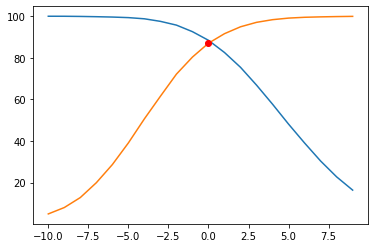

array([0.])

In [ ]:
x = [number/magnitude for number in range(-10*magnitude, 10*magnitude)]
pos_array = np.array(pos_accuracy)
neg_array = np.array(neg_accuracy)
x_array = np.array(x)

plt.plot(x_array, pos_array)
plt.plot(x_array, neg_array)

idx = np.argwhere(np.diff(np.sign(pos_array - neg_array))).flatten()
plt.plot(x_array[idx], neg_array[idx], 'ro')
plt.show()

x_array[idx]